In [1]:
import os
import getpass
import bs4
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.messages import HumanMessage

os.environ['USER_AGENT'] = 'myagent'

# Only keep post title, headers, and content from the full HTML.
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")

USER_AGENT environment variable not set, consider setting it to identify your requests.


Total characters: 43131


In [14]:
from langchain_ollama import ChatOllama

llm = ChatOllama(model="llama3.2")

In [2]:
print(docs[0].page_content[:500])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


In [3]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 66 sub-documents.


In [4]:
all_splits[1]

Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 971}, page_content='Memory\n\nShort-term memory: I would consider all the in-context learning (See Prompt Engineering) as utilizing short-term memory of the model to learn.\nLong-term memory: This provides the agent with the capability to retain and recall (infinite) information over extended periods, often by leveraging an external vector store and fast retrieval.\n\n\nTool use\n\nThe agent learns to call external APIs for extra information that is missing from the model weights (often hard to change after pre-training), including current information, code execution capability, access to proprietary information sources and more.')

In [5]:
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_ollama import OllamaEmbeddings, ChatOllama
embeddings = OllamaEmbeddings(model="llama3.2")
vector_store = InMemoryVectorStore(embeddings)

In [7]:
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['e0955b6e-11c6-4b25-b4d5-0b42bad28b97', '015f10ba-02e7-4749-abea-cb1cd7dec72b', 'fcc47652-2958-4db1-995c-9ac5d66eb10e']


In [8]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

C:\Users\Administrator\anaconda3\envs\llm\Lib\site-packages\langsmith\client.py:241: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


In [9]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [10]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [11]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

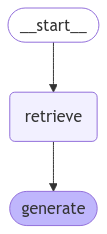

In [12]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
result = graph.invoke({"question": "What is Self-Reflection?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='fcc47652-2958-4db1-995c-9ac5d66eb10e', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1585}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'), Document(id='23a1ae37-ee67-4640-a2b8-ba8dca92bf77', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 11628}, page_content='Fig. 8. Categorization of human memory.\nWe can

In [16]:
query = 'What are the key components of an agent system?'

In [17]:
results = vector_store.similarity_search(query, k=2)

In [18]:
results


[Document(id='2bd7f318-3c40-47f5-a635-9f730e411de7', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 17804}, page_content='The AI assistant can parse user input to several tasks: [{"task": task, "id", task_id, "dep": dependency_task_ids, "args": {"text": text, "image": URL, "audio": URL, "video": URL}}]. The "dep" field denotes the id of the previous task which generates a new resource that the current task relies on. A special tag "-task_id" refers to the generated text image, audio and video in the dependency task with id as task_id. The task MUST be selected from the following options: {{ Available Task List }}. There is a logical relationship between tasks, please note their order. If the user input can\'t be parsed, you need to reply empty JSON. Here are several cases for your reference: {{ Demonstrations }}. The chat history is recorded as {{ Chat History }}. From this chat history, you can find the path of the user-mentioned resources f

In [20]:
results[1]

Document(id='af77d94a-75d0-4e88-9451-06952b1e67cf', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 20471}, page_content='API-Bank (Li et al. 2023) is a benchmark for evaluating the performance of tool-augmented LLMs. It contains 53 commonly used API tools, a complete tool-augmented LLM workflow, and 264 annotated dialogues that involve 568 API calls. The selection of APIs is quite diverse, including search engines, calculator, calendar queries, smart home control, schedule management, health data management, account authentication workflow and more. Because there are a large number of APIs, LLM first has access to API search engine to find the right API to call and then uses the corresponding documentation to make a call.')

In [24]:
def augement_prompt(query:str):
    results = vector_store.similarity_search(query, k=3)
    source_knowledge = '\n'.join([x.page_content for x in results])
    augement_prompt = f"""Using the contets below, answer the query.
    
    contexts:
    {source_knowledge}
    
    query:{query}"""
    
    return augement_prompt

In [29]:
query = 'What are the Types of Memory ?'
print(augement_prompt(query))

Using the contets below, answer the query.
    
    contexts:
    Fig. 7. Comparison of AD, ED, source policy and RL^2 on environments that require memory and exploration. Only binary reward is assigned. The source policies are trained with A3C for "dark" environments and DQN for watermaze.(Image source: Laskin et al. 2023)
Component Two: Memory#
(Big thank you to ChatGPT for helping me draft this section. I’ve learned a lot about the human brain and data structure for fast MIPS in my conversations with ChatGPT.)
Types of Memory#
Memory can be defined as the processes used to acquire, store, retain, and later retrieve information. There are several types of memory in human brains.


Sensory Memory: This is the earliest stage of memory, providing the ability to retain impressions of sensory information (visual, auditory, etc) after the original stimuli have ended. Sensory memory typically only lasts for up to a few seconds. Subcategories include iconic memory (visual), echoic memory (au

In [30]:
from langchain.schema import HumanMessage, SystemMessage, AIMessage
messages = [
    SystemMessage(content='You are a helpful assistant!'),
    HumanMessage(content='knock knock!'),
    AIMessage(content='What;s there?'),
]
prompt = HumanMessage(content=augement_prompt(query))
messages.append(prompt)
chat = ChatOllama(model ='llama3.2')
res = chat(messages)

In [31]:
res

AIMessage(content='According to the provided context, there are three types of memory:\n\n1. **Sensory Memory**: This is the earliest stage of memory that provides the ability to retain impressions of sensory information (visual, auditory, etc) after the original stimuli have ended. It typically only lasts for up to a few seconds.\n2. **Short-Term Memory (STM)**: Also known as Working Memory, it stores information that we are currently aware of and needed to carry out complex cognitive tasks such as learning and reasoning. It is believed to have a capacity of about 7 items and lasts for 20-30 seconds.\n3. **Long-Term Memory (LTM)**: This type of memory can store information for a remarkably long time, ranging from a few days to decades, with an essentially unlimited storage capacity. There are two subtypes:\n\t* **Explicit/Declarative Memory**: This refers to memories that can be consciously recalled, including episodic memory (events and experiences) and semantic memory (facts and con

In [28]:
query

'What are the key components of an agent system?'